# Build Convolutional Neural Networks From Scratch

In [39]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

## 1. Load Data

In [40]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


def convEncoding(input):
    result = []
    for code in input:
        inner = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        inner[code] = 1.0
        result.append(inner)

    return result

def normalize(x):
    maximum = np.max(x)
    minimum = np.min(x)
    return(x - minimum) / (maximum - minimum)

# This is the function that returns data
# The load_data() function returns the label that is NOT one-hot encoding
def load_data(norm = False):
    files = [data_dir + str(i) for i in range(1, 6)]
    files_test = data_dir_test + 'test_batch'
    data_batch = unpickle(files[0])
    data_batch_test = unpickle(files_test)

    # image_data: the numpy array of combined image data from 5 batch files
    image_data = data_batch[b'data']
    image_data_test = data_batch_test[b'data']

    # label_data: array of labels combined from 5 batch files
    label_data = data_batch[b'labels']
    label_data_test = data_batch_test[b'labels']

    for file in files[1:5]:
        data_batch = unpickle(file)
        image_data = np.concatenate((image_data, data_batch[b'data']), axis=0)
        label_data += data_batch[b'labels']

    images_train = image_data
    images_test = image_data_test

    labels_train = np.asarray(label_data)
    labels_test = np.asarray(label_data_test)
    
    # read in names of classes
    class_names = ['airplane','automobile','bird','cat',
                   'deer','dog','frog','horse','ship','truck']

    if (norm == True):
        images_train = normalize(images_train)
        images_test = normalize(images_test)

    return images_train, images_test, labels_train, labels_test, class_names


In [41]:
data_dir = "D:/AML/FinalProject/data/cifar-10-batches-py/data_batch_"
data_dir_test = "D:/AML/FinalProject/data/cifar-10-batches-py/"
# labels are not one-hot-encoding!
images_train, images_test, labels_train, labels_test, class_names = load_data()
print("Data loaded: ")
print("==>training data shape:", images_train.shape)
print("==>test data shape:", images_test.shape)

Data loaded: 
==>training data shape: (50000, 3072)
==>test data shape: (10000, 3072)


## 2. Data Preprocessing

In [42]:
def reshape(images, width):
    
    '''reshape the input into 32x32x3 np.ndarray'''
    
    # input images should be a 2-dimensional np.array 
    # e.g: [[1,2,3,...]] for one image only
    first = images.shape[0]
    result = np.zeros((first, width, width, 3))
    index = 0
    for image in images:
#         assert len(image) == width*width*3
        # Get color out of original array
        redPixel = image[0:width*width]/255
        greenPixel = image[width*width:width*width*2]/255
        bluePixel = image[width*width*2:width*width*3]/255
        reshaped = np.zeros((32, 32, 3))
        for i in range(0, width): #row
            for j in range(0, width): #column
                point = np.zeros(3)
                point[0] = redPixel[i*32+j]
                point[1] = greenPixel[i*32+j]
                point[2] = bluePixel[i*32+j]
                # add to result
                reshaped[i][j] = point
        result[index] = reshaped
        index += 1
            
    return result

In [43]:
images_train_reshaped = reshape(images_train, 32)
images_test_reshaped = reshape(images_test, 32)
print("Data reshaped: ")
print("==>training data reshaped:", images_train_reshaped.shape)
print("==>test data reshaped:", images_test_reshaped.shape)

Data reshaped: 
==>training data reshaped: (50000, 32, 32, 3)
==>test data reshaped: (10000, 32, 32, 3)


In [44]:
def distorted_image(image, cropped_size, training):    
    '''This function takes a single image from training set as input'''
    
    if training:
        # Randomly crop the input image.
        image = tf.random_crop(image, size=[cropped_size, cropped_size, 3])

        # Randomly flip the image horizontally.
        image = tf.image.random_flip_left_right(image)

        # Randomly adjust hue, contrast and saturation.
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)

        # Limit the image pixels between [0, 1] in case of overflow.
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    
    else:
        # Crop the input image around the centre so it is the same
        # size as images that are randomly cropped during training.
    
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                       target_height=cropped_size,
                                                       target_width=cropped_size)
    
    return image



def preprocess(images,cropped_size,training):   
    '''This function takes multiple images as input,
    will call distorted_image()'''

    images = tf.map_fn(lambda image: distorted_image(image, cropped_size,training), images)
    
    return images


## 3. CNN models

In [35]:
def prediction (logits):
    predicted_class = tf.argmax(logits, 1, name='pred_class')
    return predicted_class

def compute_accuracy(logits, y):
    prediction = tf.argmax(logits, 1, name='pred_class')
    true_label = tf.argmax(y, 1, name='true_class')
    accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, true_label), tf.float64))
    return accuracy

def compute_cross_entropy(logits, y):
    # Compute the average cross-entropy across all the examples.
    sm_ce = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=logits, name='cross_ent_terms')
    cross_ent = tf.reduce_mean(sm_ce, name='cross_ent')
    return cross_ent

def conv(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding="SAME")

def maxpool(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def fractional_maxpool(x):
    return tf.nn.fractional_max_pool(x, pooling_ratio=[1, 1.44, 1.44, 1])

def cp_cp_fc_fc_logits(x):

    x_image = tf.cast(x, tf.float32)
    n_conv1 = 64
    n_conv2 = 64


    W_conv1 = tf.get_variable("W_conv1", shape = [5,5,3,n_conv1])
    b_conv1 = tf.get_variable("b_conv1", shape = [n_conv1])
    h_conv1 = tf.nn.relu(tf.add(conv(x_image, W_conv1), b_conv1))
    p_1 = maxpool(h_conv1)
    
    W_conv2 = tf.get_variable("W_conv2", shape=[5,5,n_conv1, n_conv2])
    b_conv2 = tf.get_variable("b_conv2", shape=[n_conv2])
    h_conv2 = tf.nn.relu(tf.add(conv(p_1, W_conv2), b_conv2))
    p_2 = maxpool(h_conv2)
    p_2_drop = tf.nn.dropout(p_2, 0.8)
    
    p_2_flatten = tf.reshape(p_2, [-1, 6*6*n_conv2])
    W_fc1 = tf.get_variable('W_fc1', shape=[6*6*n_conv2, 256])
    b_fc1 = tf.get_variable('b_fc1', shape=[256])
    h_fc1 = tf.nn.relu(tf.add(tf.matmul(p_2_flatten, W_fc1), b_fc1))

    W_fc2 = tf.get_variable("W_fc2", shape=[256, 128])
    b_fc2 = tf.get_variable("b_fc2", shape=[128])
    h_fc2 = tf.nn.relu(tf.add(tf.matmul(h_fc1, W_fc2), b_fc2))

    W_fc3 = tf.get_variable('W_fc3', shape=[128, 10])
    b_fc3 = tf.get_variable('b_fc3', shape=[10])
    logits = tf.add(tf.matmul(h_fc2, W_fc3), b_fc3, name='cp_cp_fc_fc_logits')

    print('Check shape before flatten layer:', p_2.get_shape())
    return(logits)

### 3.1 Prepare parameters for runing model

In [38]:
# change to one-hot-encoding
labels_train = convEncoding(labels_train)
labels_test = convEncoding(labels_test)
labels_train = np.asarray(labels_train)
labels_test = np.asarray(labels_test)

cropped_size = 24
learning_rate = 0.05
max_steps = 500
batch_size = int(len(labels_train)/max_steps)
print("Images cropped size is {:g}".format(cropped_size))
print("Batch size is {:g}".format(batch_size))
print("Max steps in each batch is {:g}".format(max_steps))
print("Learning rate is {:g}".format(learning_rate))

TypeError: only integer scalar arrays can be converted to a scalar index

### 3.2 Main model (GPU Version)

In [ ]:
tf.reset_default_graph()
# change here: define a graph
with tf.Graph().as_default():
    start_time = time.time()
    print('starting time', start_time)
    
    x = tf.placeholder(tf.float32, [None, 32,32,3], name="x")
    y = tf.placeholder(tf.float32, [None, 10], name = "y")
#     prob_keep_1 = tf.placeholder(tf.float32, name="prob_keep_1")
#     prob_keep_2 = tf.placeholder(tf.float32, name="prob_keep_2")
#     prob_keep_3 = tf.placeholder(tf.float32, name="prob_keep_3")
#     prob_keep_4 = tf.placeholder(tf.float32, name="prob_keep_4")
#     prob_keep_5 = tf.placeholder(tf.float32, name="prob_keep_5")
    
    training = True
    
    with tf.variable_scope("preprocess", reuse=not training):
        preprocessed_data = preprocess(x,cropped_size,training) #tensor with distorted images
    with tf.variable_scope("model", reuse=not training):
        logits = cp_cp_fc_fc_logits(preprocessed_data)
    with tf.variable_scope("loss",reuse=not training):
        loss = compute_cross_entropy(logits=logits, y=y)
    with tf.variable_scope("accuracy", reuse=not training):
        accuracy = compute_accuracy(logits, y)
    with tf.variable_scope("prediction", reuse=not training):
        pred_class = prediction(logits)
    with tf.variable_scope("training"):
        train_step = tf.train.AdamOptimizer(0.00001).minimize(loss)
    
    saver = tf.train.Saver()
    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)

    sess.run(tf.global_variables_initializer())
        
    # save loss and accuracies here
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []
    
    with tf.device("/device:GPU:0"):        
        for index in range(0, 1000):
            loss_list = []
            acc_list = []
            print("This is the {:g}th epochs!!!".format(index))
            for i in range(max_steps):
                training = True
                images_batch = images_train_reshaped[i * batch_size: (i + 1) * batch_size]
                labels_batch = labels_train[i * batch_size: (i + 1) * batch_size]

                _ , loss_val, acc_val = sess.run((train_step,loss,accuracy), feed_dict={x:images_batch, y:labels_batch})
                
                loss_list.append(loss_val)
                acc_list.append(acc_val)
                
                if i%200==0:
                    print("> it is the {:g}th iteration".format(i))
                    
            epoch_loss_train = sum(loss_list)/ float(len(loss_list))
            train_loss.append(epoch_loss_train)
            epoch_acc_train =  sum(acc_list)/ float(len(acc_list))
            train_accuracy.append(epoch_acc_train)
            
            print("--> Train accuracy for {:g}th epoch: ".format(index), epoch_acc_train)
            
            if index%100 == 0:
                saver.save(sess, '../output/scratch/my-model', global_step=index)
            
            # output accuracy, loss, predicted labels
            acc_list = []
            loss_list = []
            pred_labels =[]
            for i in range(0, 100):
                training =False
                loss_val, acc_val, pred_val = sess.run((loss,accuracy, pred_class),
                          feed_dict={x: images_test_reshaped[i*100:i*100+100], 
                                     y: labels_test[i*100:i*100+100]})
                loss_list.append(loss_val)
                acc_list.append(acc_val)
                pred_labels.append(pred_val)
                
            epoch_loss_test = sum(loss_list)/ float(len(loss_list))
            test_loss.append(epoch_loss_test)
            epoch_acc_test =  sum(acc_list)/ float(len(acc_list))
            test_accuracy.append(epoch_acc_test)
            
            print("--> Test accuracy for {:g}th epoch: ".format(index), epoch_acc_test)
            print("=========================================")
        end_time = time.time()
        process_timg = end_time - start_time


### 3.3 Results

In [13]:
import pandas as pd
accuracyDF = pd.DataFrame(train_accuracy)
accuracyDF.reset_index(inplace=True)
accuracyDF.columns = ['epoch', 'train_accuracy']
accuracyDF['test_accuracy'] = test_accuracy
# accuracyDF.to_csv("../output/scratch/acc.csv")

lossDF = pd.DataFrame(train_loss)
lossDF.reset_index(inplace=True)
lossDF.columns = ['epoch', 'train_loss']
lossDF['test_loss'] = test_loss
# lossDF.to_csv("../output/scratch/loss.csv")

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

# Functions for plots
def plot_result(acc, loss):
    fig, axs = plt.subplots(1, 2,figsize=(10, 5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(acc)+1),acc['train_accuracy'])
    axs[0].plot(range(1,len(acc)+1),acc['test_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(acc)+1),len(acc['train_accuracy'])/10)
    axs[0].legend(['train', 'test'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(loss)+1),loss['train_loss'])
    axs[1].plot(range(1,len(loss)+1),loss['test_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(acc)+1),len(loss['train_loss'])/10)
    axs[1].legend(['train', 'test'], loc='best')
    plt.show()

#### Plots for Accuracy and Loss

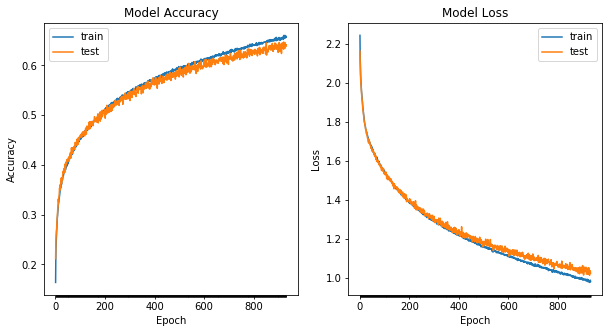

In [25]:
plot_result(accuracyDF, lossDF)

#### Plot Mis-classified Images

In [48]:
def plot_images(images, TrueClass, PredClass=None, width=32, isReshape=True):
    
    '''show images: 
    input np.ndarray, output images with true or predicted class labels'''

#     assert len(images) == len(TrueClass) == 10

    # Each image as a sub-plot: totally 2 rows 5 columns
    fig, axes = plt.subplots(2, 5)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    if isReshape:
        reshaped_images = reshape(images, width)
    else:
        reshaped_images = images

    for i, ax in enumerate(axes.flat):
        # Plot image and smooth it
        ax.imshow(reshaped_images[i],
                   interpolation='spline16')
            
        # Name of the true class.
        TrueName = class_names[TrueClass[i]]

        if PredClass is None:
            # Only show True class names
            xlabel = "True: {0}".format(TrueName)
        else:
            # Show both True and Pred class names
            PredName = class_names[PredClass[i]]
            xlabel = "True: {0}\nPred: {1}".format(TrueName, PredName)

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()
    
def plot_example_errors(cls_pred, cls_true):
    # This function is called from print_test_accuracy() below.
    count_incorrect = 0
    image_index = []
    true_classes = []
    pred_classes = []
    for i in range(len(cls_true)):
        if count_incorrect < 10:
            if cls_true[i] != cls_pred[i]:
                count_incorrect += 1
                image_index.append(i)
                true_classes.append(cls_true[i])
                pred_classes.append(cls_pred[i])
    images =  images_test_reshaped[image_index]
    plot_images(images,
                TrueClass=true_classes,
                PredClass=pred_classes,  
                width=32, 
                isReshape=False)   
    
    print('true labels:', true_classes)
    print('pred labels:', pred_classes)
    # return(image_index, true_classes, pred_classes)


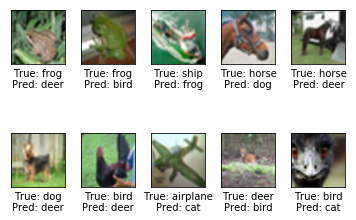

true labels: [6, 6, 8, 7, 7, 5, 2, 0, 4, 2]
pred labels: [4, 2, 6, 5, 4, 4, 4, 3, 2, 3]


In [49]:
plot_example_errors(pred_labels[0], labels_test[0:100])

#### Plot Confusion Matrix

In [50]:
def plot_confusion_matrix(cls_pred, cls_true):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(10):
        # Append the class-name to each line.
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    # Print the class-numbers for easy reference.
    class_numbers = [" {0}".format(i) for i in range(10)]
    print("".join(class_numbers))

In [53]:
plot_confusion_matrix(pred_labels[2], labels_test[200:300])

[8 2 1 0 0 0 0 1 3 1] (0) airplane
[0 9 0 0 0 0 0 0 0 1] (1) automobile
[1 0 2 0 0 2 0 1 0 0] (2) bird
[0 0 0 6 0 3 1 0 0 0] (3) cat
[2 0 1 0 4 0 0 1 0 0] (4) deer
[0 0 1 1 0 7 0 0 1 0] (5) dog
[0 0 0 2 0 0 5 1 0 0] (6) frog
[0 0 0 2 0 1 0 6 0 0] (7) horse
[2 2 0 0 0 0 0 0 5 0] (8) ship
[0 2 0 0 0 0 0 0 3 9] (9) truck
 0 1 2 3 4 5 6 7 8 9
